In [85]:
import numpy as np
import matplotlib.pyplot as plt
import enzyme_utils_new as utils
import scipy.stats as stats
import scipy
from sklearn.neighbors import KernelDensity

%config InlineBackend.figure_format='retina'

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Hierarchical BM
Here we apply a hierarhical model to selected enzyme tracks

In [40]:
la = ['buffer', '10um', '100um', '1mm', '10mm', '100mm']
BI = [np.loadtxt('temp_save/BI_'+la[i]+'.txt').astype(int) for i in range(6)]

In [61]:
data_dir = ['new_data/transformed_buffer/', 'new_data/transformed_10uM/',  'new_data/transformed_100uM/', 
            'new_data/transformed_1mM/', 'new_data/transformed_10mM/', 'new_data/transformed_100mM/']

enzymes = utils.enzymeBayes(data_dir, ml=20, jump=3)

15 files; 234 trajectories (length >= 20); Total 19117 data points
23 files; 116 trajectories (length >= 20); Total 8442 data points
37 files; 324 trajectories (length >= 20); Total 19651 data points
27 files; 403 trajectories (length >= 20); Total 32292 data points
33 files; 261 trajectories (length >= 20); Total 16986 data points
38 files; 326 trajectories (length >= 20); Total 18992 data points


In [62]:
enzymes.ignoreLongJump()

In [63]:
xx = [np.loadtxt('temp_save/sel_'+la[i]+'.txt').astype(int) for i in range(6)]

In [83]:
map_tot = []

for i in range(6): 
    
    map_tot.append(enzymes.computeHyperParams(i, xx[i]))

alpha = 4.103703, beta = 4.513248, optimize success = True
alpha = 6.401626, beta = 7.830023, optimize success = True
alpha = 1.746947, beta = 1.769612, optimize success = True
alpha = 1.163148, beta = 1.045819, optimize success = True
alpha = 2.102004, beta = 2.014469, optimize success = True
alpha = 1.393289, beta = 0.987766, optimize success = True


## When Hierarchical Model is helpful

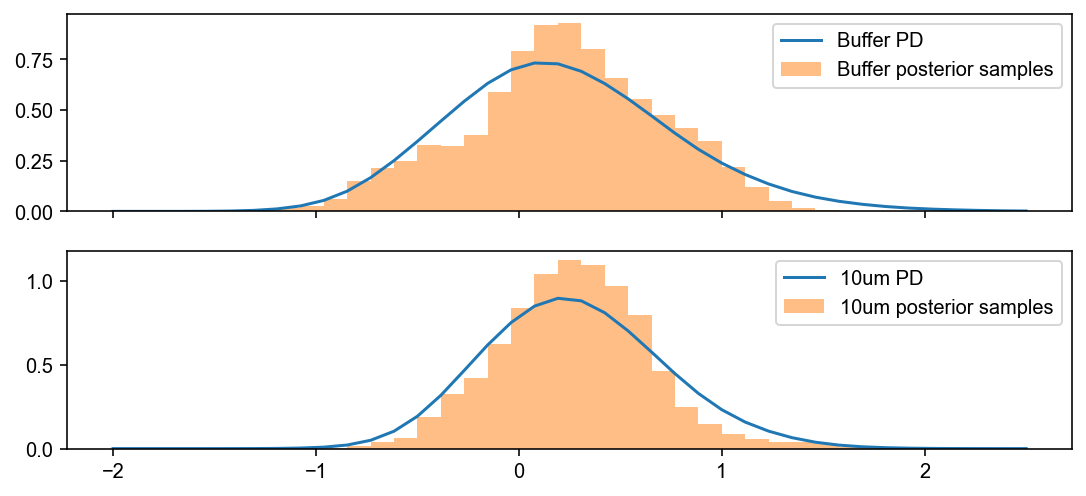

In [86]:
fig, axes = plt.subplots(2, 1, figsize=(9, 4), sharex=True)

bin_array = np.linspace(-2, 2.5, 40)
alpha_, beta_ = map_tot[0][0], map_tot[0][1]
log_samples = np.log(stats.invgamma.rvs(a=alpha_, scale=beta_, size=4000))
kde = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(log_samples.reshape(-1, 1))
den = np.exp(kde.score_samples(bin_array[:, np.newaxis]))

d_trace = np.zeros((len(xx[0]), 4000))
for j, ind_ in enumerate(xx[0]):
    sx, sy, st = enzymes.loadSelectTraj(0, ind_)
    sdx, sdy, sdt = np.diff(sx), np.diff(sy), np.diff(st)
    s = np.sum((sdx ** 2 + sdy ** 2) / (4 * sdt))
    D_samples = stats.invgamma.rvs(a=alpha_ + len(sdx), scale=beta_ + s, size=4000)
    d_trace[j, :] = D_samples
    
axes[0].plot(bin_array, den)
axes[0].hist(np.log(d_trace[:, ::4]).flatten(), bins=bin_array, density=True, alpha=0.5)
axes[0].legend(['Buffer PD', 'Buffer posterior samples'])
# axes[0].legend('mean')

bin_array = np.linspace(-2, 2.5, 40)
alpha_, beta_ = map_tot[1][0], map_tot[1][1]
log_samples = np.log(stats.invgamma.rvs(a=alpha_, scale=beta_, size=4000))
kde = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(log_samples.reshape(-1, 1))
den = np.exp(kde.score_samples(bin_array[:, np.newaxis]))

d_trace = np.zeros((len(xx[1]), 4000))
for j, ind_ in enumerate(xx[1]):
    sx, sy, st = enzymes.loadSelectTraj(1, ind_)
    sdx, sdy, sdt = np.diff(sx), np.diff(sy), np.diff(st)
    s = np.sum((sdx ** 2 + sdy ** 2) / (4 * sdt))
    D_samples = stats.invgamma.rvs(a=alpha_ + len(sdx), scale=beta_ + s, size=4000)
    d_trace[j, :] = D_samples
    
axes[1].plot(bin_array, den)
axes[1].hist(np.log(d_trace[:, ::4]).flatten(), bins=bin_array, density=True, alpha=0.5)
axes[1].legend(['10um PD', '10um posterior samples'])
# # plt.hist(log_samples, bins=bin_array, density=True, alpha=0.5)


plt.show()

Shrinkage plot for 10um datast

In [88]:
ranking, tl, index, map_, avg_dt = enzymes.rank(1, xx[1], ml=20)

In [89]:
ind = [i for i in range(len(index))]
dtype = [('log_d', float), ('index', int)]
order = 'log_d'
utils.sort_by_entry([tl, ind], dtype, order)

In [90]:
b1 = np.where(np.array(tl) <=25)[0][-1]
b2 = np.where(np.array(tl) <=50)[0][-1]
b3 = np.where(np.array(tl) <=100)[0][-1]

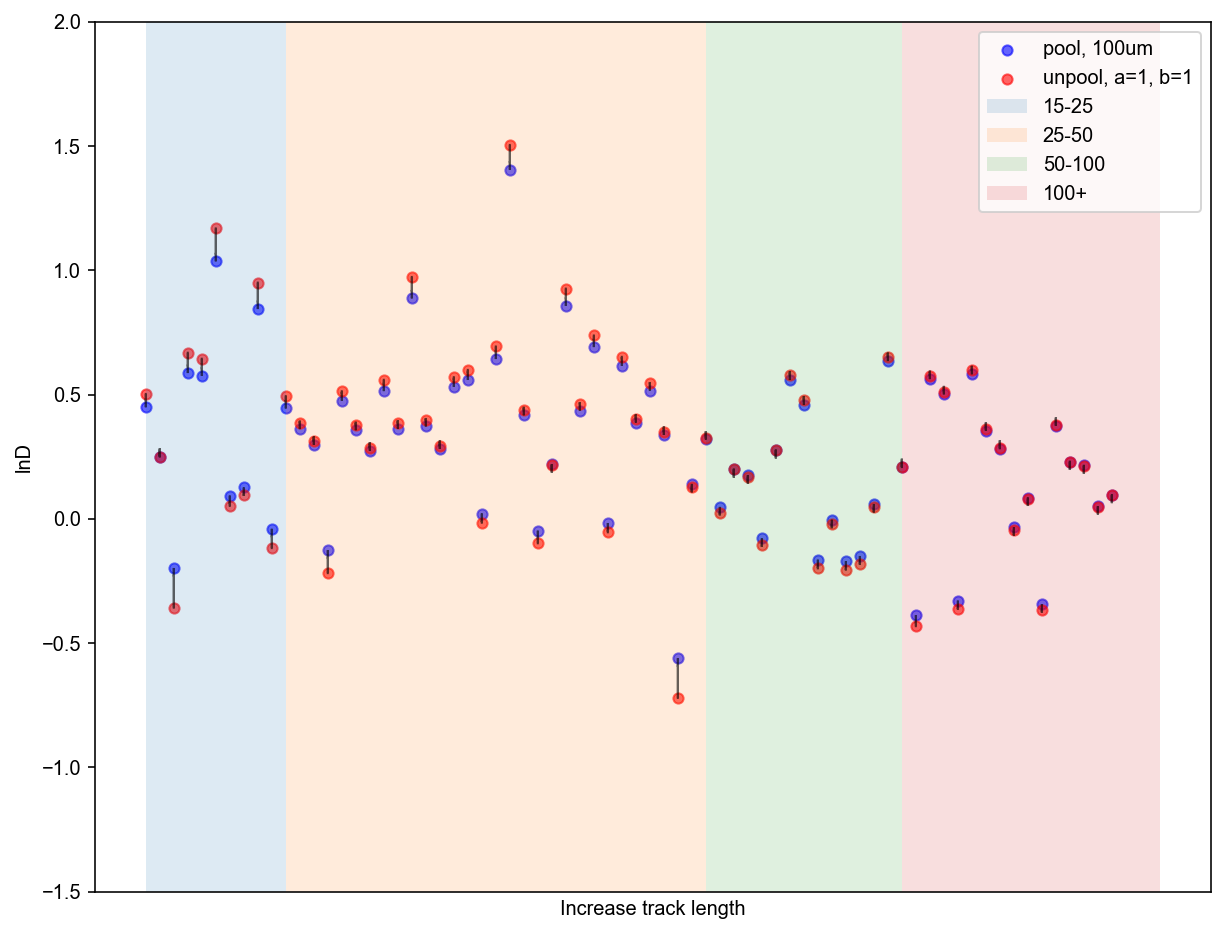

In [94]:
plt.figure(figsize=(10, 8))
plt.scatter([i for i in range(len(index))], np.log(np.mean(d_trace, axis=1))[ind], \
            s=26, alpha=0.6, label='pool, 100um', c='b')
plt.scatter([i for i in range(len(index))], np.log(map_)[ind], \
            s=26, alpha=0.6, label='unpool, a=1, b=1', c='r')
plt.ylim(-1.5, 2)
plt.xlabel('Increase track length')
plt.ylabel('lnD')
plt.xticks([])
x1, x2, y1, y2 = plt.xlim()[0], plt.xlim()[1], plt.ylim()[0], plt.ylim()[1]

plt.fill_between([0, b1],  [y1, y1], [y2, y2], alpha=0.15, label='15-25')
plt.fill_between([b1, b2], [y1, y1], [y2, y2], alpha=0.15, label='25-50')
plt.fill_between([b2, b3], [y1, y1], [y2, y2], alpha=0.15, label='50-100')
plt.fill_between([b3, x2], [y1, y1], [y2, y2], alpha=0.15, label='100+')
plt.legend()

for i in range(len(index)):
    plt.arrow(
        i,
        np.log(map_)[ind][i],
        0,
        np.log(np.mean(d_trace, axis=1))[ind][i] - np.log(map_)[ind][i],
        fc="k",
        ec="k",
        length_includes_head=True,
        alpha=0.6,
        head_width=0.02,
    )

    
plt.show()

Compare buffer and 10um dataset using population statistic 

In [100]:
pixelToM, frameToS = 0.106e-6, 0.08

In [98]:
mean_buf = (map_tot[0][1]) / ( map_tot[0][0]-1)
mean_10um = map_tot[1][1] / (map_tot[1][0]-1)
mode_buf = (map_tot[0][1]) / ( map_tot[0][0]+1)
mode_10um = map_tot[1][1] / (map_tot[1][0]+1)

In [106]:
lol = [mean_buf, mean_10um, mode_buf, mode_10um]
print('Buffer population mean: %s m^2/s' %(lol[0]*pixelToM**2/frameToS))
print('10um population mean: %s m^2/s' %(lol[1]*pixelToM**2/frameToS))
print('Buffer population mode: %s m^2/s' %(lol[2]*pixelToM**2/frameToS))
print('10um population mode: %s m^2/s' %(lol[3]*pixelToM**2/frameToS))

Buffer population mean: 2.0423530546149302e-13 m^2/s
10um population mean: 2.0359177763004285e-13 m^2/s
Buffer population mode: 1.242011367130929e-13 m^2/s
10um population mode: 1.485790634906948e-13 m^2/s


In [117]:
print('precent increase in D = %f' %((mode_10um-mode_buf)*100/mode_buf))

precent increase in D = 19.627781


## When Hierarchical Model is not helpful

In [95]:
param = [(80, 0.1), (80, 0.1), (60, 0.15), (60, 0.3), (70, 0.15), (50, 0.24)]
sample_size = 4000
d_trace_tot = []

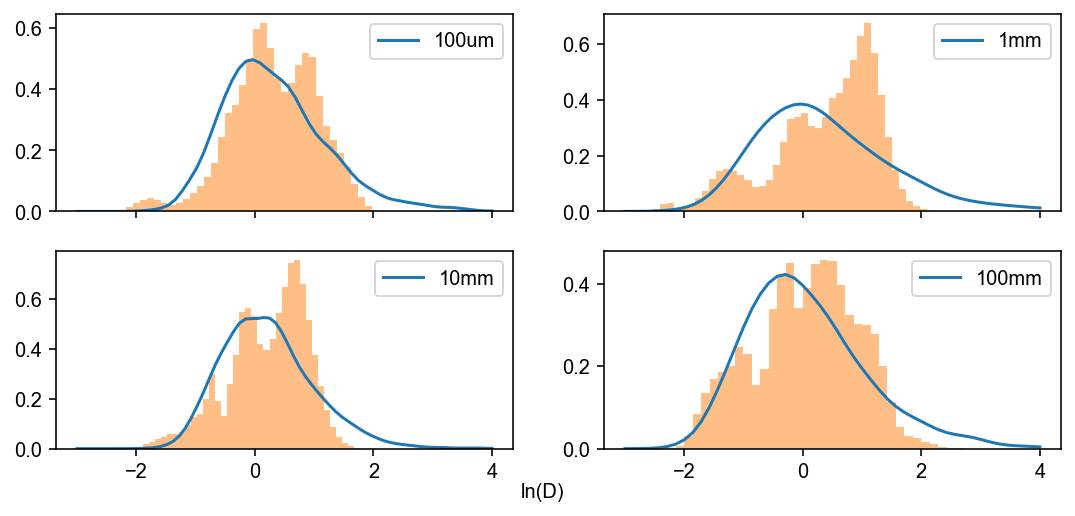

In [97]:
fig, axes = plt.subplots(2, 2, figsize=(9, 4), sharex=True)
row = 0
column = 0
for i in range(4): 
    
    inddd = i
    i = i + 2
    ran, bw = param[i][0], param[i][1]
    bin_array = np.linspace(-3, 4, ran)
    
    alpha_, beta_ = map_tot[i][0], map_tot[i][1]
    log_samples = np.log(stats.invgamma.rvs(a=alpha_, scale=beta_, size=4000))
    kde = KernelDensity(kernel='gaussian', bandwidth=bw).fit(log_samples.reshape(-1, 1))
    den = np.exp(kde.score_samples(bin_array[:, np.newaxis]))
    
    if inddd == 2: 
        row = 1
        column = 0
        
    d_trace = np.zeros((len(xx[i]), sample_size))
    for j, ind_ in enumerate(xx[i]):
        sx, sy, st = enzymes.loadSelectTraj(i, ind_)
        sdx, sdy, sdt = np.diff(sx), np.diff(sy), np.diff(st)
        s = np.sum((sdx ** 2 + sdy ** 2) / (4 * sdt))
        D_samples = stats.invgamma.rvs(a=alpha_ + len(sdx), scale=beta_ + s, size=sample_size)
        d_trace[j, :] = D_samples

    axes[row, column].plot(bin_array, den, label=la[i])
    axes[row, column].hist(np.log(d_trace[:, ::4]).flatten(), bins=bin_array, density=True, alpha=0.5)
    axes[row, column].legend()
    column += 1 
    
fig.text(0.5, 0.04, 'ln(D)', ha='center')
plt.show()